In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join


In [20]:
from keras.preprocessing import image
data_filenames = []
for root, dirs, files in os.walk('data/raw_images/'):  
    for filename in files:
        data_filenames.append(filename)

data = [mpimg.imread('data/raw_images/' + filename) for filename in (data_filenames)]

annot_filenames = []
for root, dirs, files in os.walk('data/class_color/'):  
    for filename in files:
        annot_filenames.append(filename)
        
annot = [image.load_img('data/class_color/' + filename) for filename in (annot_filenames)]

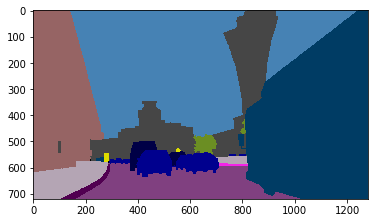

In [22]:
nb_samples=len(data_filenames)
valid_split = 0.2
test_split = 0.1

data_train = data[0:int(nb_samples*(1-valid_split-test_split))]
annot_train = annot[0:int(nb_samples*(1-valid_split-test_split))]
data_valid = data[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
annot_valid = annot[int(nb_samples*(1-valid_split-test_split)):int(nb_samples*(1-test_split))]
data_test  = data[int(nb_samples*(1-test_split)):]
annot_test  = annot[int(nb_samples*(1-test_split)):]

image = annot_valid[0]
plt.imshow(image)
plt.show()


In [4]:
categories = pd.read_csv('data/categories.csv', sep=',')
categories.head()
print('Number of categories:', len(categories), "\n")


Number of categories: 41 



In [5]:
#number of dataset
print(len(data))

100


In [6]:
subcat = []
no_subcat = 0
for row in categories.name:
    subcat.append(row)
no_subcat = len(subcat)

cat = []
for row in categories.category:
    cat.append(row)

catid = []
for row in categories.catId:
    catid.append(row)
no_cat = 1
act = catid[0]
for i in range(len(catid)):
    if catid[i]!=act:
        no_cat+=1
        act=catid[i]

col = []
for row in categories.color:
    c = row.replace(" ", "").split(',')
    rgb = []
    for i in c:
        rgb.append(int(i))
    col.append(rgb)

print("Subcategories and their representational colors [R, G, B]: \n")
for i in range(len(subcat)):
    print("%30s \t" % subcat[i], end ="")
    print(col[i])

print("\nSubcategories by their categories: \n")
act = cat[0]
print(cat[0] + ":")
for i in range(no_subcat):
    if cat[i] != act:
        print("\n" + cat[i] + ":")
        act=cat[i]
    print("\t\t"+subcat[i])

Subcategories and their representational colors [R, G, B]: 

                     unlabeled 	[0, 0, 0]
                       dynamic 	[111, 74, 0]
                   ego vehicle 	[0, 0, 0]
                        ground 	[81, 0, 81]
                        static 	[0, 0, 0]
                       parking 	[250, 170, 160]
                    rail track 	[230, 150, 140]
                          road 	[128, 64, 128]
                      sidewalk 	[244, 35, 232]
                        bridge 	[150, 100, 100]
                      building 	[70, 70, 70]
                         fence 	[190, 153, 153]
                        garage 	[180, 100, 180]
                    guard rail 	[180, 165, 180]
                        tunnel 	[150, 120, 90]
                         wall  	[102, 102, 156]
                        banner 	[250, 170, 100]
                     billboard 	[220, 220, 250]
                  lane divider 	[255, 165, 0]
                  parking sign 	[220, 20, 60]
              